### Single-GPU benchmarks of different multiple RHS (mRHS) 9-point stencil kernels
We benchmark the performance of two different approaches to a 9-point multiple rhs matrix-vector stencil.

### Setup
The setup is a set of lattices (several matrix and vector fields) on a 4D Grid (here `8.8.8.8`).
The matrices have `N x N` shape, the vectors subsequently are of size `N`.
We test the values `N = 32, 64`.
The number of right hand sizes is given by `numRHS = 1, 12, 24, 36, 48, 60`. 
Each kernel is run 100 times and the average of the faster 50% of the runs is shown.
The results are shown with 3 different normalizations:   
- `1` (None)  
- `numRHS*N**2` (flops-normalized)  
- `N**2 + 2*N*numRHS` (bandwidth-normalized)  

### Kernels

#### blas
This kernel uses the cuBLAS library.
Since there is no native mRHS matrix-vector call, we use the `gemmStridedBatched` and `gemmBatched` routine.
These routines perform matrix-matrix mul on a batch of matrices, the first one additionally assumes a fixed stride between memory locations of the matrices, hence `Strided`. 
Initially, the set of vector fields are transform to a single matrix field (see plots: `cp-in`, orange).
Additionally, the data of a matrix must be contiguous in memory, so a Grid-style memory layout requires extra transformation work.
After the transformation the cuBLAS kernel can be called (see plots: `op`, green).
Finally, the resulting matrix field must be transformed back into a set of vector field (see plots: `cp-out`, red).

Notes:
This kernel is unbeatably performant at normal matrix-matrix multiplication but it does not exploit the fact that the vectors can be kept in shmem (user managed cache) for all nine points of the stencil.

#### 2dbtv2
This is my homemade implementation and exploits the fact, that the batch of vectors can be kept in shmem for all nine stencil points.
Additionally no copy-in or copy-out is required as the transformation is made during the copy into the shmem.
The performance speaks for itself.
In principal there is still a lot to be desired for this kernel and better flops/bandwidth can be achieved in theory.
Theoretically, an improvement factor of three could be possible.

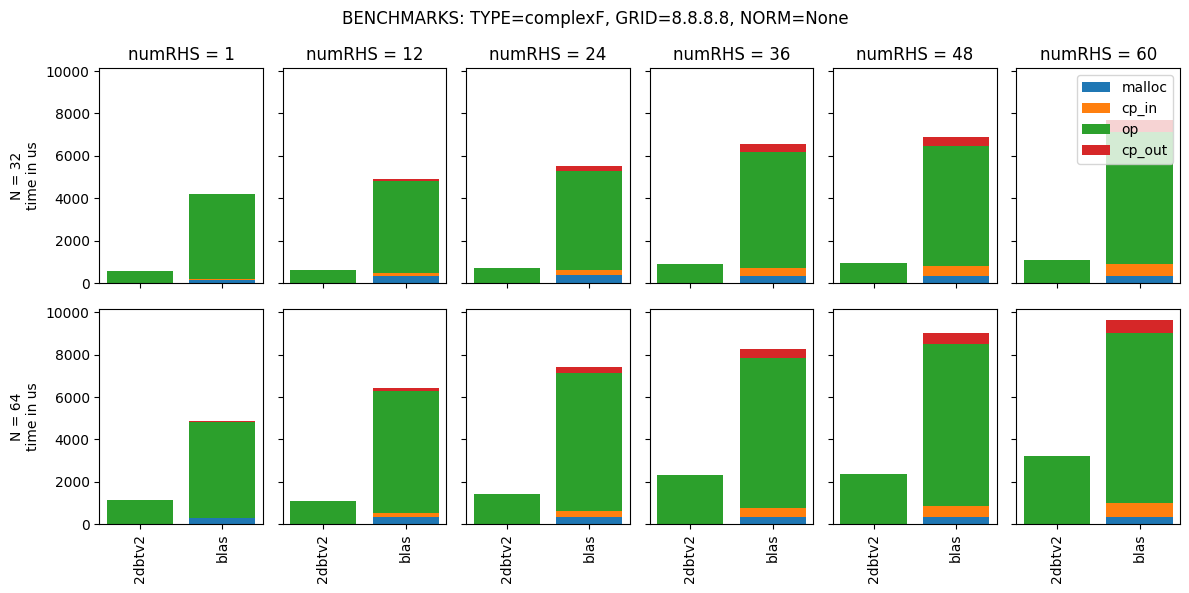

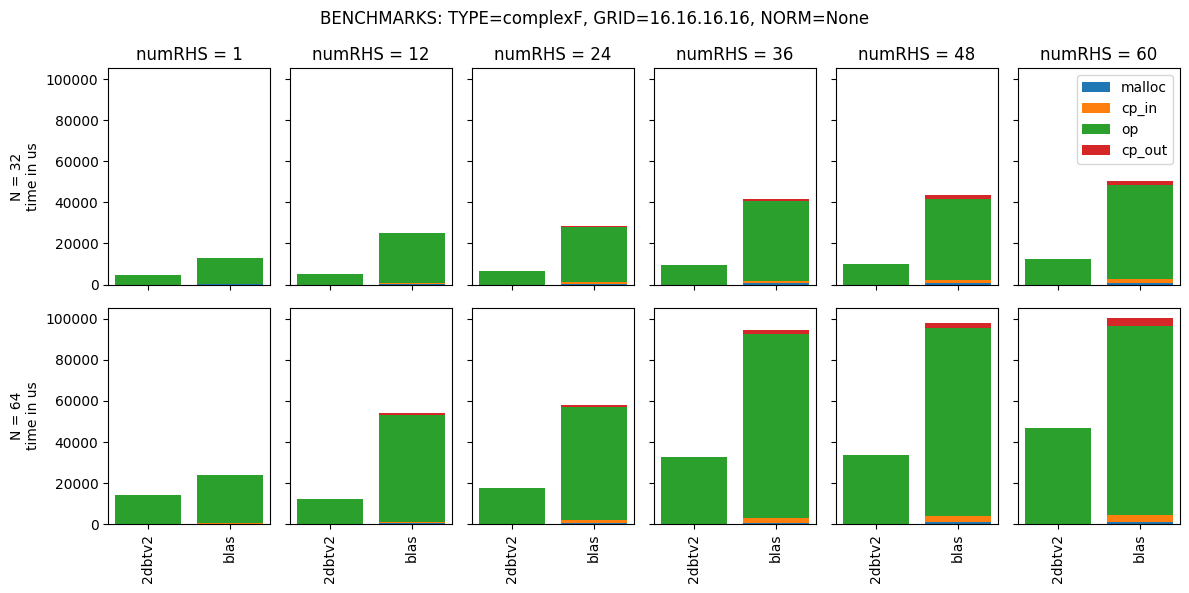

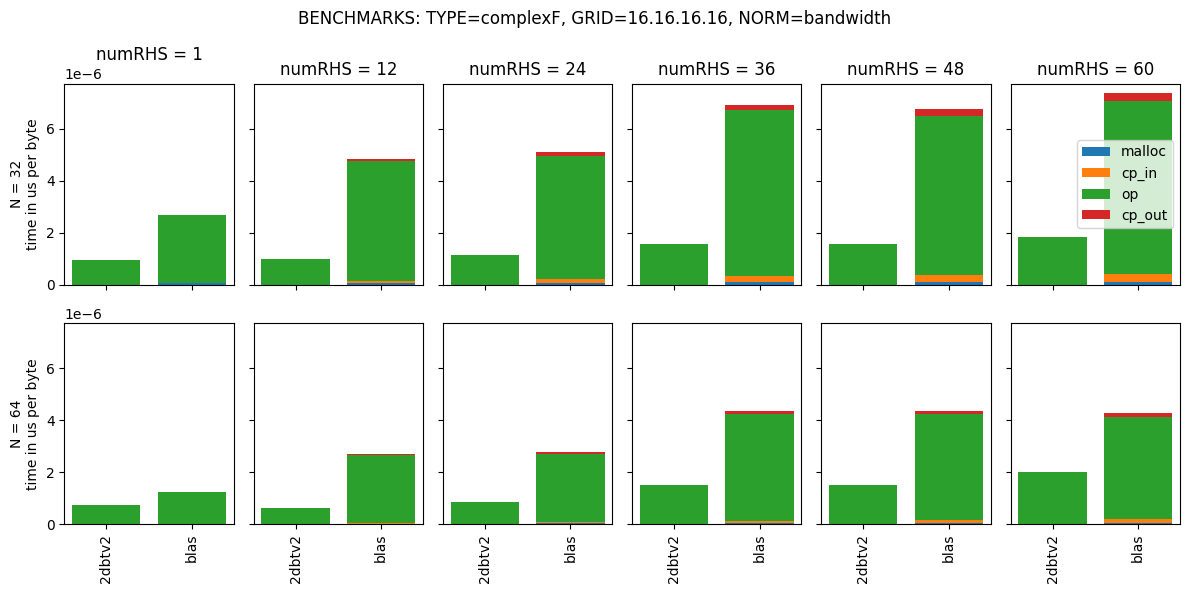

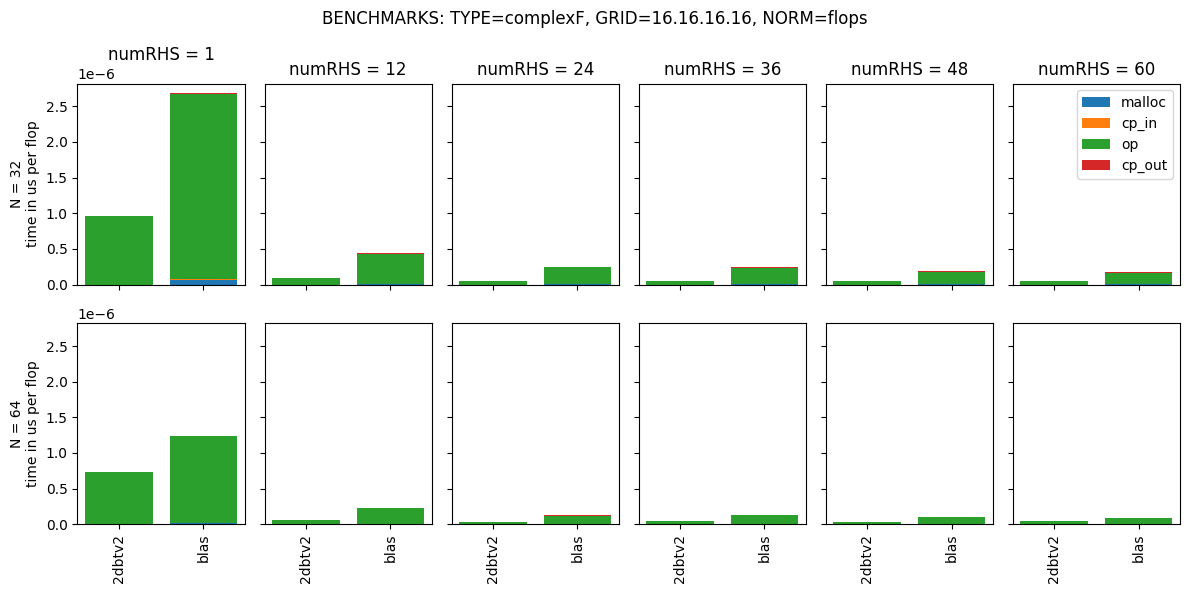

In [1]:
import os
os.chdir(os.getenv("HOME") + "/phd/cuda_grid/runs/nine_point_stencil")
import pyBench as pyBench

data = pyBench.load()
plotter = pyBench.Plotter(data)
plotter.reduce()
plotter.plot_fixed_grid(grid='8.8.8.8')
plotter.plot_fixed_grid(grid='16.16.16.16')
plotter.plot_fixed_grid(grid='16.16.16.16', normalization="bandwidth")
plotter.plot_fixed_grid(grid='16.16.16.16', normalization="flops")